In [1]:
import theano
import theano.tensor as T
import lasagne
import h5py
import numpy as np
import sys

sys.path.append("..")
from networks import  residual_unet, debug_net

In [4]:
# DATASET_TRAIN = '/home/sebastianschlecht/depth_data/nyu_v1_shuffled_cc'
# DATASET = '/home/sebastianschlecht/depth_data/nyu_depth_v2_resized'

DATASET_TRAIN = '/home/sebastianschlecht/depth_data/f3d_train'
DATASET = '/home/sebastianschlecht/depth_data/f3d_test'

DATASET = DATASET_TRAIN 
model = None#'../data/resunet_food_spatial_mse_epoch_30.npz'
f = h5py.File(DATASET + ".hdf5")
length = f["images"].shape[0]
images = np.array(f["images"][0:]).astype(np.float32)
images_orig = images.copy()
depths = np.array(f["depths"][0:]).astype(np.float32)
m = np.load(DATASET_TRAIN + ".npy").astype(np.float32)
for i in range(images.shape[0]):
    images[i] = (images[i] - m) / 71.571201304890508
    

input_var = T.tensor4('inputs')
network = residual_unet(input_var=input_var, connectivity=3)
# Downsample factor
ds = 2
prediction = lasagne.layers.get_output(network, deterministic=True)

if model is not None:
    print "Loading model weights %s" % model
    with np.load(model) as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(network, param_values)
fn = theano.function([input_var], prediction)

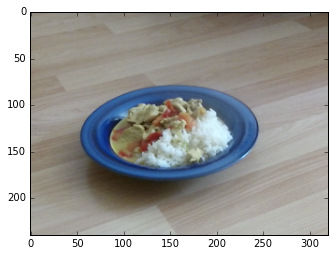

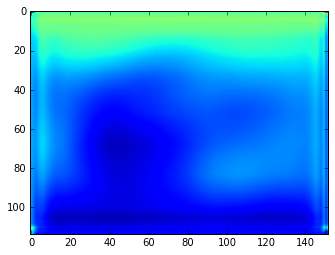

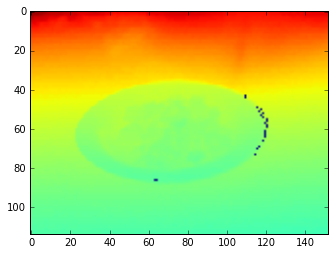

0.146717


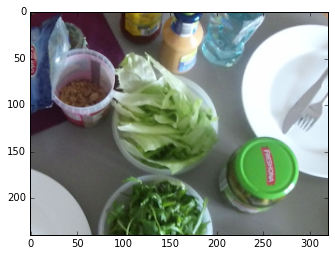

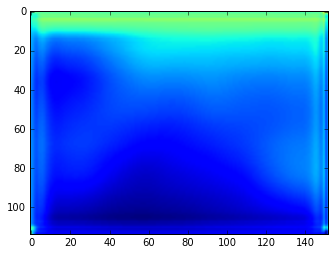

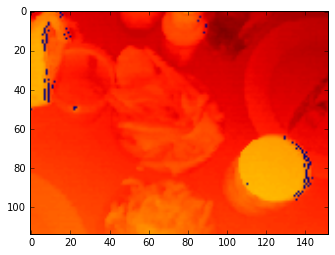

0.145163


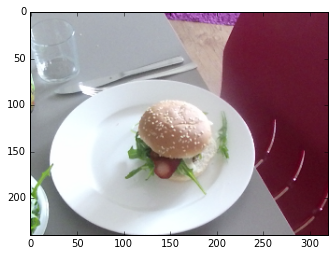

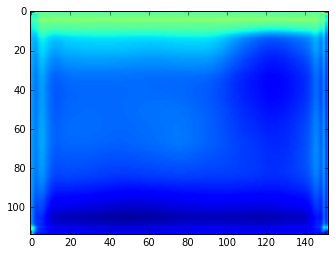

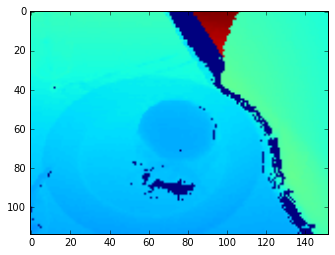

0.272806


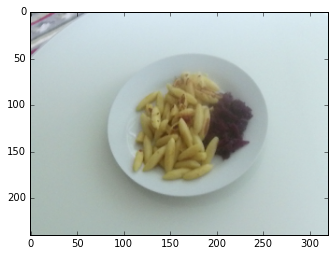

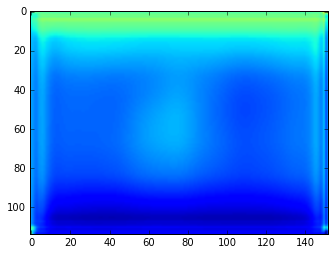

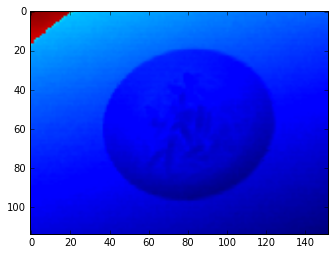

0.230254


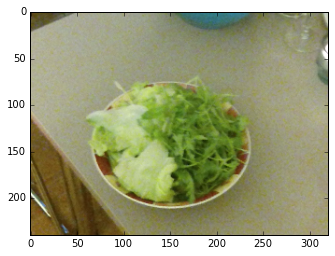

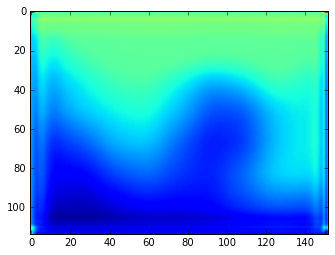

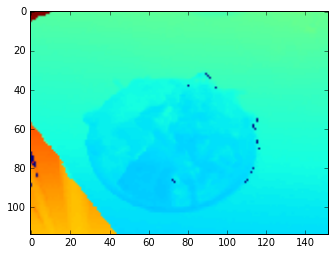

0.310275


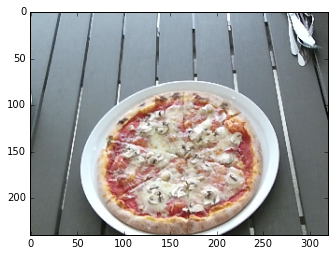

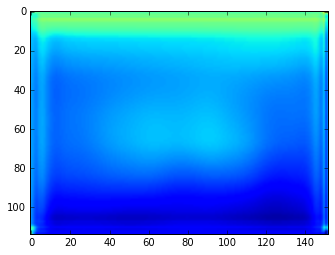

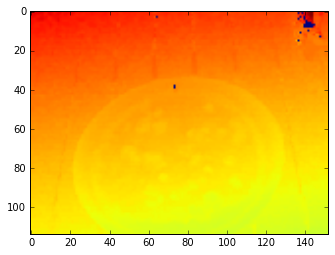

0.172793


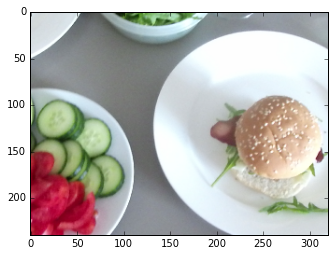

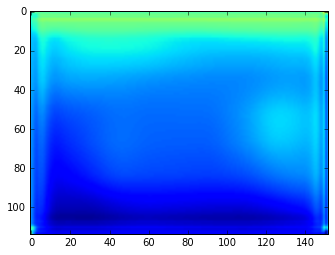

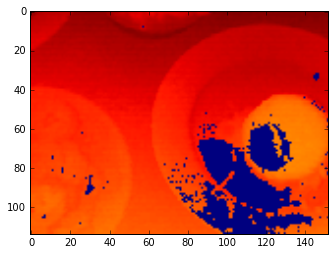

0.228321


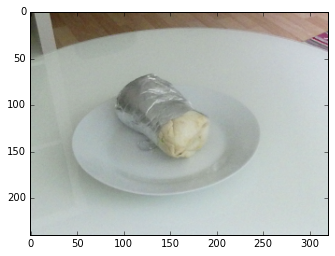

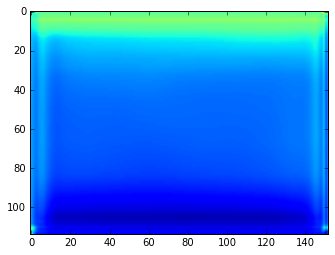

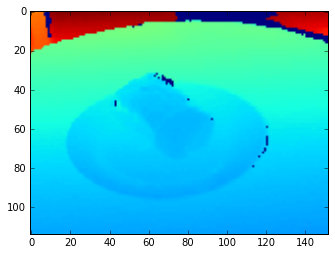

0.385323
0.249191


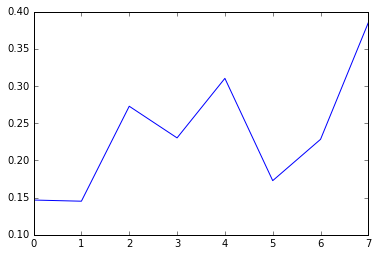

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
mm = []
ds = 2
bs = 2
out = 0
errors = []
min_res = 9999999.
min_idx = 0
min_out = None
for idx in range(8,16,bs):
    sample = images[idx:idx+bs,:,6:6+228, 8:8+304].astype(np.float32)
    r = fn(sample.reshape((-1,3,228,304)))
    d = depths[idx:idx+bs, 6:6+228, 8:8+304]
    d = d[:,::ds,::ds]
    d = d[:,np.newaxis,:,:]
    assert d.shape == r.shape
    
    #r = np.exp(r)
    m = (((d) - (r)) ** 2)
    
    #m [d <= 0] = 0
    fl = m.flatten()
    mm.append(fl)
    for iii in range(m.shape[0]):
        res = np.sqrt(m[iii].mean())
        errors.append(res)
        if res < min_res:
            min_res = res
            min_idx = idx + iii
            min_sample = r[iii]
        if True:
            out += 1
            if out % 1 == 0:
                index = idx + iii
                plt.imshow(images_orig[index].astype(np.uint8).transpose((1,2,0)))
                plt.show()
                plt.imshow(r[iii].squeeze())
                plt.show()
                plt.imshow(d[iii].squeeze())
                plt.show()
                print res
print np.sqrt(np.concatenate(mm).mean())
errors = np.array(errors)
plt.plot(errors)
plt.show()


In [37]:
import numpy
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """ 
     
    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."
        

    if window_len<3:
        return x
    
    
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
    

    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')
    
    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y    

Number of samples: 		750
Epochs: 			0
Delta iters until next epoch: 	1344
Mean of last 2k datapoints: 	0.24204818706
Mean of last 100 datapoints: 	0.117113561748
Total mean is: 			0.24204818706


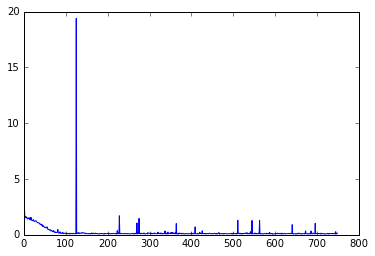

Number of samples: 		30
Epochs: 			30
Abs value of last datapoint: 	0.174229615238
Total mean is: 			0.226601340171


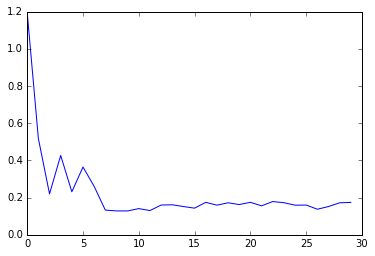

In [38]:
import numpy as np
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
# DATASET_TRAIN = '/home/sebastianschlecht/depth_data/nyu_v1_shuffled_cc'
# DATASET = '/home/sebastianschlecht/depth_data/nyu_depth_v2_resized'
DATASET_TRAIN = '/home/sebastianschlecht/depth_data/f3d_train'
DATASET = '/home/sebastianschlecht/depth_data/f3d_test'
 
f = h5py.File(DATASET_TRAIN + ".hdf5")

def plot_d(ttype):
    d = np.load("../data/resunet_food_spatial_mse_low_lr_epoch_30_loss_%s.npy" % ttype)
    print "Number of samples: \t\t",len(d)

    if ttype == "train":
        wlen = 1
        print "Epochs: \t\t\t", d.shape[0] // (33508 // 16)
        print "Delta iters until next epoch: \t", (((d.shape[0] // (33508 // 16)) + 1) * (33508 // 16)) - d.shape[0]
        print "Mean of last 2k datapoints: \t", d[-2000:].mean()
        print "Mean of last 100 datapoints: \t", d[-100:].mean()
    else:
        wlen = 1
        print "Epochs: \t\t\t", d.shape[0]
        print "Abs value of last datapoint: \t", d[-1]

    print "Total mean is: \t\t\t", d.mean()
    plt.plot(smooth(d[:], window_len=wlen))
    plt.show()

plot_d("train")
plot_d("val")





In [ ]:
import sys
import h5py
import numpy as np
sys.path.append("..")
from main import start_prefetching_thread, iterate_minibatches_synchronized

%matplotlib inline
import matplotlib.pyplot as plt
DATASET_TRAIN = "/home/sebastianschlecht/depth_data/nyu_v1_shuffled_cc"

# Validation dataset that we keep in memory
DATASET_VAL = "/home/sebastianschlecht/depth_data/nyu_depth_v2_resized"
print "Starting data prefetcher"
f = h5py.File(DATASET_TRAIN + ".hdf5")

length = f["images"].shape[0]
f.close()
batch_size = 16
ds = 2
start_prefetching_thread((batch_size, True))
for batch in iterate_minibatches_synchronized(batch_size, batch_size, augment=True, downsample=ds):
    inputs, targets = batch
    for idx in range(inputs.shape[0]):
        plt.imshow(inputs[idx].astype(np.uint8).transpose((1,2,0)))
        plt.show()
        plt.imshow(targets[idx])
        plt.show()
               
               